# Import libraries, load and transform data

In [1]:
# Install necessary Python packages using pip

# Use the 'pip' command to install packages
# The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
# We're installing the following packages:
# - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
# - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
# - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks

# Note: Before running this code, make sure you have Python and pip installed on your system.
# Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).
%pip install -U -q evaluate transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install imblearn
%pip install accelerate
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Import necessary libraries
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from datasets import Dataset, DatasetDict

In [6]:
# Define the base directory path
base_dir = Path('./AircraftRecognitionDataset/dataoriginal')

# Initialize empty lists to store file names and labels for training, validation, and testing
train_file_names, train_labels = [], []
val_file_names, val_labels = [], []
test_file_names, test_labels = [], []

# Define the directory path for images
directory_path = base_dir / 'images'

# Define the paths to the text files containing the label to manufacturer mapping
mapping_files = {
    "train": base_dir / 'images_manufacturer_train.txt',
    "val": base_dir / 'images_manufacturer_val.txt',
    "test": base_dir / 'images_manufacturer_test.txt'
}

# Initialize dictionaries to store the mappings
label_to_manufacturer = {"train": {}, "val": {}, "test": {}}

# Read the mappings from the text files
for split, file_path in mapping_files.items():
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            label = parts[0]
            manufacturer = ' '.join(parts[1:])
            label_to_manufacturer[split][label] = manufacturer

# Iterate through all image files in the specified directory
for file in tqdm(sorted(directory_path.glob('*.*g'))):  # Adjust the pattern if needed
    label = file.stem  # Extract the label from the file name (without extension)
    for split in ["train", "val", "test"]:
        if label in label_to_manufacturer[split]:
            manufacturer = label_to_manufacturer[split].get(label, 'Unknown')
            eval(f"{split}_labels").append(manufacturer)
            eval(f"{split}_file_names").append(str(file))

# Create pandas dataframes from the collected file names and labels
train_df = pd.DataFrame({"image": train_file_names, "label": train_labels})
val_df = pd.DataFrame({"image": val_file_names, "label": val_labels})
test_df = pd.DataFrame({"image": test_file_names, "label": test_labels})

# Print dataframe shapes
print(f"Train Data: {train_df.shape}")
print(f"Validation Data: {val_df.shape}")
print(f"Test Data: {test_df.shape}")

# Combine the dataframes into a single dataset
dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

# Print the dataset in a table format
print("\nDatasetDict:")
print(f"{'Split':<12} {'Features':<20} {'Num Rows':<10}")
print(f"{'-'*12} {'-'*20} {'-'*10}")
for split, dataset in dataset_dict.items():
    print(f"{split:<12} {str(dataset.features):<20} {dataset.num_rows:<10}")

# Load in the families, manufacturers, variants files
files = {
    "families": base_dir / 'families.txt',
    "manufacturers": base_dir / 'manufacturers.txt',
    "variants": base_dir / 'variants.txt'
}

# Initialize lists to store the contents
contents = {key: [] for key in files}

# Read the files
for key, file_path in files.items():
    with open(file_path, "r") as f:
        contents[key] = [line.strip() for line in f]

# Print the first few entries to verify
print("\nFamilies, Manufacturers, Variants:")
print(f"{'File':<15} {'First 5 Entries':<50}")
print(f"{'-'*15} {'-'*50}")
for key in contents:
    print(f"{key.capitalize():<15} {contents[key][:5]}")

# Load in all the test files
test_files = {
    "family": base_dir / 'images_family_test.txt',
    "manufacturer": base_dir / 'images_manufacturer_test.txt',
    "test": base_dir / 'images_test.txt',
    "variant": base_dir / 'images_variant_test.txt'
}

# Initialize dictionaries to store the mappings
test_mappings = {key: {} for key in test_files if key != "test"}
test_image_ids = []

# Read the test files
for key, file_path in test_files.items():
    with open(file_path, "r") as f:
        if key == "test":
            test_image_ids = [line.strip() for line in f]
        else:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    image_id, label = parts
                    test_mappings[key][image_id] = label

# Print the first few entries to verify
print("\nTest:")
print(f"{'File':<20} {'First 5 Entries':<50}")
print(f"{'-'*20} {'-'*50}")
for i, (key, mapping) in enumerate(test_mappings.items(), 1):
    print(f"{i}. {key.capitalize():<20} {list(mapping.items())[:5]}")
print(f"{len(test_mappings) + 1}. Image IDs {'':<10} {test_image_ids[:5]}")

# Load in all the train files
train_files = {
    "family": base_dir / 'images_family_train.txt',
    "manufacturer": base_dir / 'images_manufacturer_train.txt',
    "train": base_dir / 'images_train.txt',
    "variant": base_dir / 'images_variant_train.txt'
}

# Initialize dictionaries to store the mappings
train_mappings = {key: {} for key in train_files if key != "train"}
train_image_ids = []

# Read the train files
for key, file_path in train_files.items():
    with open(file_path, "r") as f:
        if key == "train":
            train_image_ids = [line.strip() for line in f]
        else:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    image_id, label = parts
                    train_mappings[key][image_id] = label

# Print the first few entries to verify
print("\nTrain:")
print(f"{'File':<20} {'First 5 Entries':<50}")
print(f"{'-'*20} {'-'*50}")
for i, (key, mapping) in enumerate(train_mappings.items(), 1):
    print(f"{i}. {key.capitalize():<20} {list(mapping.items())[:5]}")
print(f"{len(train_mappings) + 1}. Image IDs {'':<10} {train_image_ids[:5]}")

# Load in the validation (val) files
val_files = {
    "family": base_dir / 'images_family_val.txt',
    "manufacturer": base_dir / 'images_manufacturer_val.txt',
    "val": base_dir / 'images_val.txt',
    "variant": base_dir / 'images_variant_val.txt'
}

# Initialize dictionaries to store the mappings
val_mappings = {key: {} for key in val_files if key != "val"}
val_image_ids = []

# Read the val files
for key, file_path in val_files.items():
    with open(file_path, "r") as f:
        if key == "val":
            val_image_ids = [line.strip() for line in f]
        else:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    image_id, label = parts
                    val_mappings[key][image_id] = label

# Print the first few entries to verify
print("\nValidation:")
print(f"{'File':<20} {'First 5 Entries':<50}")
print(f"{'-'*20} {'-'*50}")
for i, (key, mapping) in enumerate(val_mappings.items(), 1):
    print(f"{i}. {key.capitalize():<20} {list(mapping.items())[:5]}")
print(f"{len(val_mappings) + 1}. Image IDs {'':<10} {val_image_ids[:5]}")

# Load in the trainval files
trainval_files = {
    "family": base_dir / 'images_family_trainval.txt',
    "manufacturer": base_dir / 'images_manufacturer_trainval.txt',
    "variant": base_dir / 'images_variant_trainval.txt',
}

# Initialize dictionaries to store the mappings
trainval_mappings = {key: {} for key in trainval_files if key != "trainval"}
trainval_image_ids = []

# Read the trainval files
for key, file_path in trainval_files.items():
    with open(file_path, "r") as f:
        if key == "trainval":
            trainval_image_ids = [line.strip() for line in f]
        else:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    image_id, label = parts
                    trainval_mappings[key][image_id] = label

# Print the first few entries to verify
print("\nTrainval:")
print(f"{'File':<20} {'First 5 Entries':<50}")
print(f"{'-'*20} {'-'*50}")
for i, (key, mapping) in enumerate(trainval_mappings.items(), 1):
    print(f"{i}. {key.capitalize():<20} {list(mapping.items())[:5]}")

# Load in the box file
box_file = base_dir / 'images_box.txt'
box_mappings = {}

# Read the box file
with open(box_file, "r") as f:
    for line in f:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            image_id, box = parts
            box_mappings[image_id] = box

# Print the first few entries to verify
print("\nBox:")
print(f"{'File':<20} {'First 5 Entries':<50}")
print(f"{'-'*20} {'-'*50}")
print(f"1. Box {'':<20} {list(box_mappings.items())[:5]}")

100%|██████████| 1524/1524 [00:00<00:00, 46770.46it/s]

Train Data: (508, 2)
Validation Data: (502, 2)
Test Data: (514, 2)

DatasetDict:
Split        Features             Num Rows  
------------ -------------------- ----------
train        {'image': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)} 508       
validation   {'image': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)} 502       
test         {'image': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)} 514       

Families, Manufacturers, Variants:
File            First 5 Entries                                   
--------------- --------------------------------------------------
Families        ['A300', 'A310', 'A320', 'A330', 'A340']
Manufacturers   ['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing']
Variants        ['707-320', '727-200', '737-200', '737-300', '737-400']

Test:
File                 First 5 Entries                                   
-------------------- ----------------------------------------

In [7]:
print("\nDataFrame heads:")
print(train_df.head())
print(val_df.head())
print(test_df.head())


DataFrame heads:
                                               image              label
0  AircraftRecognitionDataset/dataoriginal/images...  McDonnell Douglas
1  AircraftRecognitionDataset/dataoriginal/images...             Boeing
2  AircraftRecognitionDataset/dataoriginal/images...           Canadair
3  AircraftRecognitionDataset/dataoriginal/images...         Beechcraft
4  AircraftRecognitionDataset/dataoriginal/images...             Boeing
                                               image                     label
0  AircraftRecognitionDataset/dataoriginal/images...  Douglas Aircraft Company
1  AircraftRecognitionDataset/dataoriginal/images...                    Boeing
2  AircraftRecognitionDataset/dataoriginal/images...         McDonnell Douglas
3  AircraftRecognitionDataset/dataoriginal/images...         McDonnell Douglas
4  AircraftRecognitionDataset/dataoriginal/images...      Gulfstream Aerospace
                                               image              label
0  A

In [8]:
print("\nUnique Labels:")
print("Train:", train_df["label"].unique())
print("Validation:", val_df["label"].unique())
print("Test:", test_df["label"].unique())


Unique Labels:
Train: ['McDonnell Douglas' 'Boeing' 'Canadair' 'Beechcraft' 'Airbus'
 'British Aerospace' 'Douglas Aircraft Company' 'Tupolev' 'Fokker'
 'de Havilland' 'Lockheed Corporation' 'Dornier' 'Fairchild' 'ATR'
 'Yakovlev' 'Saab' 'Embraer' 'Gulfstream Aerospace' 'Dassault Aviation'
 'Cessna' 'Piper' 'Antonov' 'Bombardier Aerospace' 'Ilyushin']
Validation: ['Douglas Aircraft Company' 'Boeing' 'McDonnell Douglas'
 'Gulfstream Aerospace' 'Beechcraft' 'de Havilland' 'Embraer' 'Fokker'
 'Fairchild' 'Tupolev' 'Airbus' 'Lockheed Corporation' 'Canadair' 'ATR'
 'Saab' 'British Aerospace' 'Dornier' 'Cessna' 'Piper' 'Antonov'
 'Ilyushin' 'Yakovlev' 'Dassault Aviation' 'Eurofighter' 'Robin']
Test: ['Boeing' 'McDonnell Douglas' 'Airbus' 'Lockheed Corporation' 'Embraer'
 'Tupolev' 'Fokker' 'Canadair' 'Douglas Aircraft Company' 'Ilyushin'
 'de Havilland' 'ATR' 'Beechcraft' 'Fairchild' 'Gulfstream Aerospace'
 'British Aerospace' 'Dornier' 'Cessna' 'Saab' 'Piper' 'Antonov'
 'Yakovlev' 'Eurofig

In [9]:
y_val = val_df[['label']]
val_df = val_df.drop(['label'], axis=1)

ros = RandomOverSampler(random_state=83)
val_df, y_val_resampled = ros.fit_resample(val_df, y_val)

del y_val
val_df['label'] = y_val_resampled
del y_val_resampled

gc.collect()
print(val_df.shape)

(3350, 2)


In [10]:
# Create a dataset from a Pandas DataFrame.
val_dataset = Dataset.from_pandas(val_df).cast_column("image", Image())

In [11]:
# Display the first image in the dataset
image = dataset[0]["image"]
display(image)

'AircraftRecognitionDataset/dataoriginal/images/0037512.jpg'

In [13]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = val_df['label'][:5].tolist()

# Printing the subset of labels to inspect the content
print(labels_subset)

['Douglas Aircraft Company', 'Boeing', 'McDonnell Douglas', 'McDonnell Douglas', 'Gulfstream Aerospace']


In [19]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(val_df['label'])))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'ATR', 1: 'Airbus', 2: 'Antonov', 3: 'Beechcraft', 4: 'Boeing', 5: 'British Aerospace', 6: 'Canadair', 7: 'Cessna', 8: 'Dassault Aviation', 9: 'Dornier', 10: 'Douglas Aircraft Company', 11: 'Embraer', 12: 'Eurofighter', 13: 'Fairchild', 14: 'Fokker', 15: 'Gulfstream Aerospace', 16: 'Ilyushin', 17: 'Lockheed Corporation', 18: 'McDonnell Douglas', 19: 'Piper', 20: 'Robin', 21: 'Saab', 22: 'Tupolev', 23: 'Yakovlev', 24: 'de Havilland'} 

Mapping of Labels to IDs: {'ATR': 0, 'Airbus': 1, 'Antonov': 2, 'Beechcraft': 3, 'Boeing': 4, 'British Aerospace': 5, 'Canadair': 6, 'Cessna': 7, 'Dassault Aviation': 8, 'Dornier': 9, 'Douglas Aircraft Company': 10, 'Embraer': 11, 'Eurofighter': 12, 'Fairchild': 13, 'Fokker': 14, 'Gulfstream Aerospace': 15, 'Ilyushin': 16, 'Lockheed Corporation': 17, 'McDonnell Douglas': 18, 'Piper': 19, 'Robin': 20, 'Saab': 21, 'Tupolev': 22, 'Yakovlev': 23, 'de Havilland': 24}
['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing', 'British Ae

In [21]:
# Count the number of instances for each label
label_counts = val_df['label'].value_counts()

# Filter out labels with fewer than two instances
valid_labels = label_counts[label_counts >= 2].index.tolist()

# Filter the dataset to include only valid labels
filtered_dataset = dataset.filter(lambda example: example['label'] in valid_labels)

# Proceed with the rest of the code
from datasets import ClassLabel

# Create classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(valid_labels), names=valid_labels)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Apply the mapping to the dataset
filtered_dataset = filtered_dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
filtered_dataset = filtered_dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets
filtered_dataset = filtered_dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset
train_data = filtered_dataset['train']

# Extracting the testing data from the split dataset
test_data = filtered_dataset['test']

Filter:   0%|          | 0/514 [00:00<?, ? examples/s]

In [30]:
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torchvision.transforms import Compose, Normalize, Resize, RandomRotation, RandomAdjustSharpness, RandomHorizontalFlip, ToTensor
from datasets import load_dataset, ClassLabel
from PIL import Image as PILImage

# Define the pre-trained ViT model string
model_str = "dima806/military_aircraft_image_detection"  # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Load your local dataset
dataset = load_dataset('images', data_dir='./AircraftRecognitionDataset/dataoriginal')

# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(dataset['train']['label'])))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

# Create classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Apply the mapping to the dataset
dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and validation sets
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")
train_dataset = dataset['train']
val_dataset = dataset['test']

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(PILImage.open(image).convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(PILImage.open(image).convert("RGB")) for image in examples['image']]
    return examples

# Apply the transformations to the training and validation datasets
train_dataset = train_dataset.map(train_transforms, batched=True)
val_dataset = val_dataset.map(val_transforms, batched=True)

# Initialize the model
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list), ignore_mismatched_sizes=True)
model.config.id2label = id2label
model.config.label2id = label2id

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=None,  # Add tokenizer if needed
    compute_metrics=None,  # Define compute_metrics function if needed
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

Size:  224


DatasetNotFoundError: Dataset 'images' doesn't exist on the Hub or cannot be accessed.

In [23]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

# Load, train, and evaluate model

In [24]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
from transformers import ViTForImageClassification

# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list), ignore_mismatched_sizes=True)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at dima806/military_aircraft_image_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([50]) in the checkpoint and torch.Size([26]) in the model instantiated
- classifier.weight: found shape torch.Size([50, 768]) in the checkpoint and torch.Size([26, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.81865


In [26]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [27]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "aircraft_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 3

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=2e-7,
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=64,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=32,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported.
    report_to="none"
)

In [28]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [29]:
from PIL import Image as PILImage

def val_transforms(examples):
    # Check if the images are already loaded as PIL images
    if isinstance(examples['image'][0], str):
        examples['pixel_values'] = [_val_transforms(PILImage.open(image).convert("RGB")) for image in examples['image']]
    else:
        examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Apply the transformations to the validation dataset
val_dataset = val_dataset.map(val_transforms, batched=True)

# Evaluate the pre-training model's performance on a test dataset
trainer.evaluate()

Map:   0%|          | 0/3350 [00:00<?, ? examples/s]

AttributeError: 'NoneType' object has no attribute 'get'

In [21]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.561400,1.668253,0.760392
2,1.560000,1.663613,0.760686
3,1.554300,1.662117,0.760850


TrainOutput(global_step=2154, training_loss=1.554349936482634, metrics={'train_runtime': 5068.1064, 'train_samples_per_second': 27.17, 'train_steps_per_second': 0.425, 'total_flos': 1.0675237576343962e+19, 'train_loss': 1.554349936482634, 'epoch': 3.0})

In [22]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 1.6621166467666626,
 'eval_accuracy': 0.7608496732026144,
 'eval_runtime': 427.4509,
 'eval_samples_per_second': 71.587,
 'eval_steps_per_second': 2.239,
 'epoch': 3.0}

In [23]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 1.6621166467666626, 'test_accuracy': 0.7608496732026144, 'test_runtime': 426.2942, 'test_samples_per_second': 71.781, 'test_steps_per_second': 2.245}


Accuracy: 0.7608
F1 Score: 0.7488


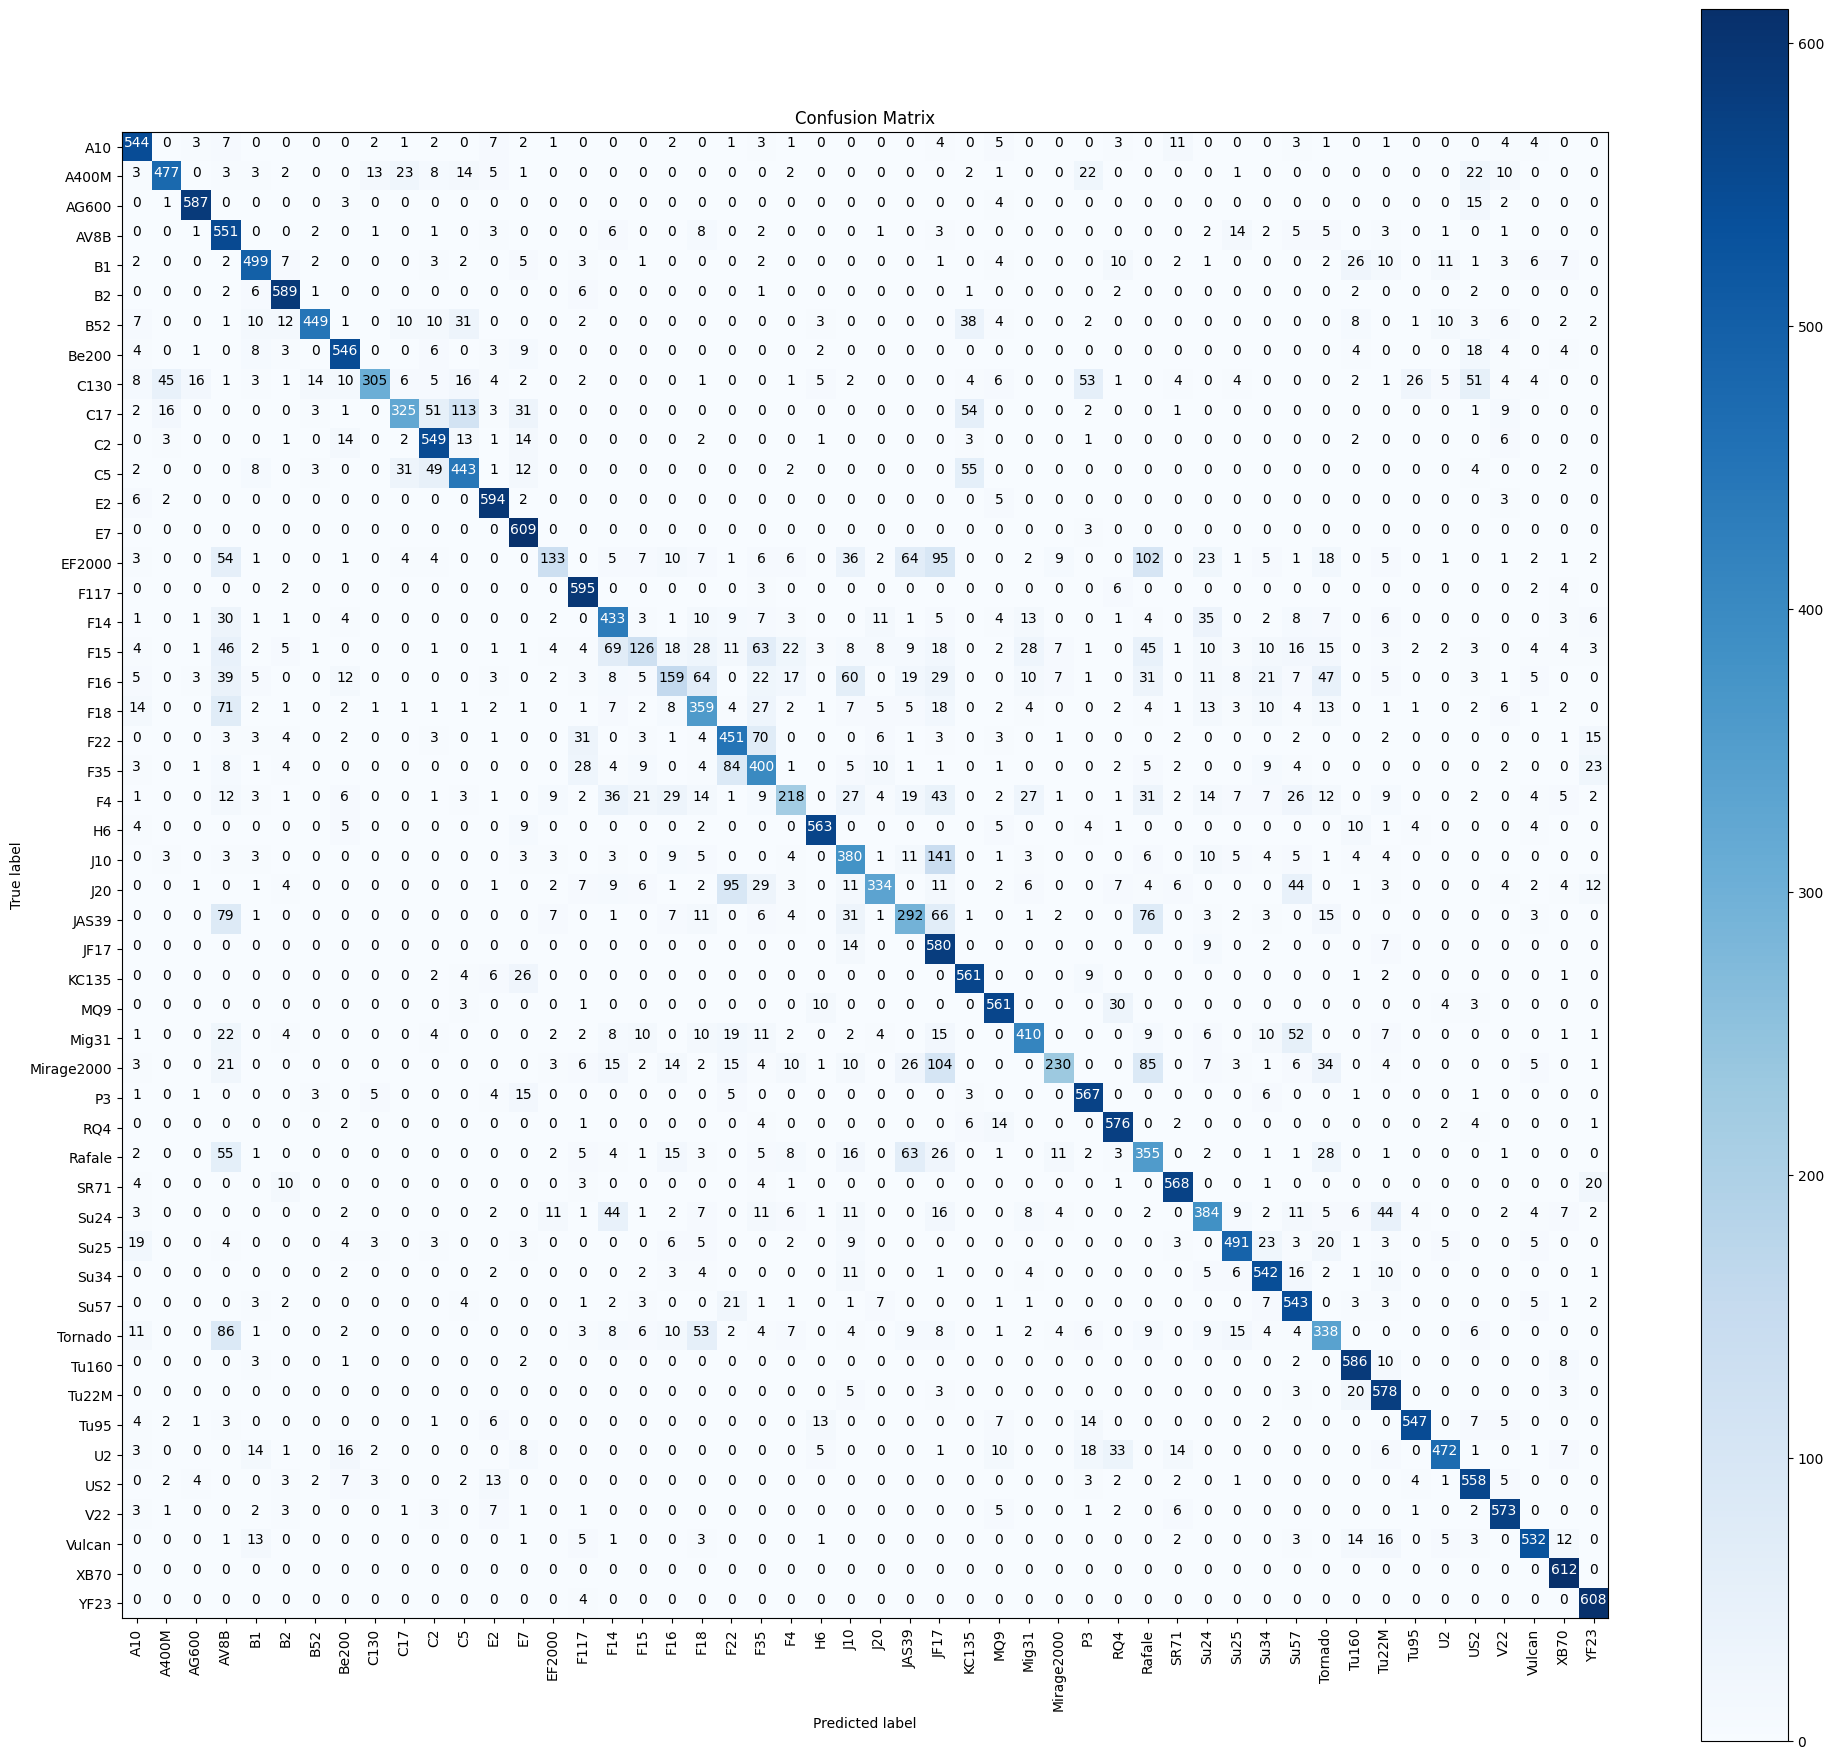


Classification report:

              precision    recall  f1-score   support

         A10     0.8156    0.8889    0.8507       612
       A400M     0.8641    0.7794    0.8196       612
       AG600     0.9452    0.9592    0.9521       612
        AV8B     0.4991    0.9003    0.6422       612
          B1     0.8358    0.8154    0.8255       612
          B2     0.8924    0.9624    0.9261       612
         B52     0.9354    0.7337    0.8223       612
       Be200     0.8491    0.8922    0.8701       612
        C130     0.9104    0.4984    0.6441       612
         C17     0.8045    0.5310    0.6398       612
          C2     0.7765    0.8971    0.8324       612
          C5     0.6826    0.7239    0.7026       612
          E2     0.8866    0.9706    0.9267       612
          E7     0.8045    0.9951    0.8897       612
      EF2000     0.7348    0.2173    0.3354       612
        F117     0.8298    0.9722    0.8954       612
         F14     0.6531    0.7075    0.6792       612
  

In [24]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(20, 18))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [25]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()

In [26]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

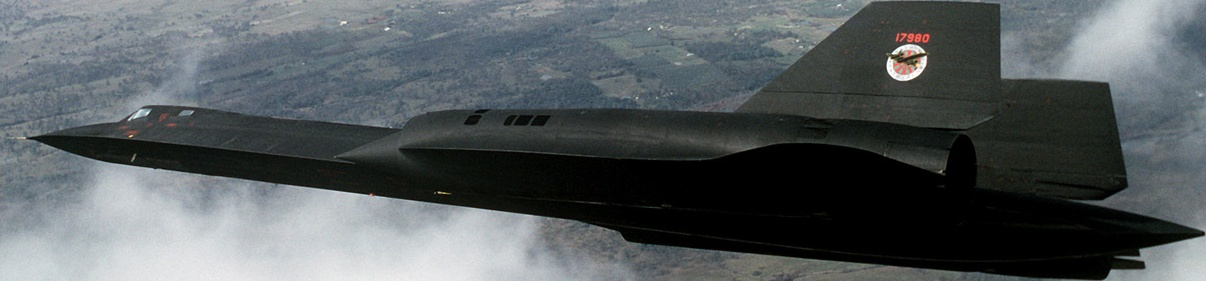

In [27]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [28]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'label': 'SR71', 'score': 0.3855471909046173},
 {'label': 'U2', 'score': 0.06835196912288666},
 {'label': 'RQ4', 'score': 0.052092816680669785},
 {'label': 'B1', 'score': 0.024586472660303116},
 {'label': 'US2', 'score': 0.02072013169527054}]

In [29]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.
# It's used to retrieve the actual label associated with a test data point.
id2label[test_data[1]["label"]]

'SR71'